In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import random

from google.cloud import storage

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import datasets

from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import keras_tuner
from kerastuner.tuners import RandomSearch

from numpy import savez_compressed
from numpy import load

from datetime import datetime

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-a891d1f2b022>:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Config

Configuration of important paths.

In [2]:
raw_path = 'data/raw'
split_path = 'data/split'

## Image Augmentation, Normalization & Resizing

### Sample Augmentation - Explore how image augmentation works

Found 631 images belonging to 3 classes.
256


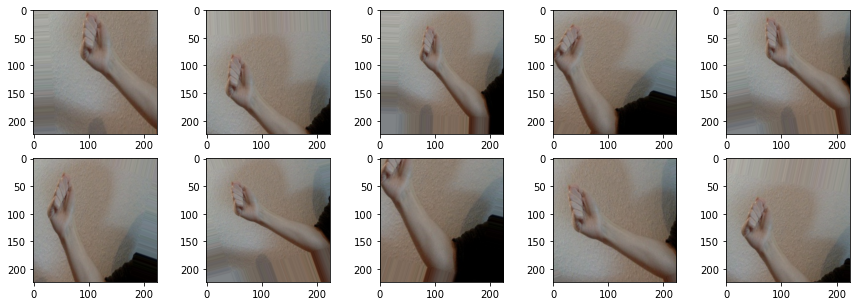

In [71]:
sample_gen = ImageDataGenerator(
    rescale=1./255 ,rotation_range=20, width_shift_range=0.2,height_shift_range=0.2, shear_range=0.2, zoom_range=0.2
    #brightness_range, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, preprocessing_function=None
)

sample_data = sample_gen.flow_from_directory(
    directory = split_path + '/train', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=1, 
    shuffle=False, 
    seed=1,
    interpolation='nearest'
)

plt.figure(figsize=(15,5))

img = np.random.randint(0, len(sample_data))
print(str(img))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(sample_data[img][0].reshape([224,224,3]))

### Train Image Augmentation

In [17]:
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
train_gen = ImageDataGenerator(
    rescale=1./255 #,rotation_range=40, width_shift_range=0.2,height_shift_range=0.2, shear_range=0.2, zoom_range=0.2
    #brightness_range, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, preprocessing_function=None
)

In [64]:
train_data = train_gen.flow_from_directory(
    directory = split_path + '/train', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=32, 
    shuffle=False, 
    seed=1,
    interpolation='nearest'
)

Found 631 images belonging to 3 classes.


In [65]:
class_names = train_data.class_indices.keys()

### Validation Image Augmentation

In [66]:
val_gen = ImageDataGenerator(rescale=1./255)

val_data = val_gen.flow_from_directory(
    directory = split_path + '/val', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=32, 
    shuffle=False, 
    seed=1,
    interpolation='nearest'
)

Found 134 images belonging to 3 classes.


## Hyperparameter optimization

In [ ]:
def build_cnn(hp):
    ####Config####
    input_pixels = 32
    input_depth = 3
    num_outputs = 10
    ####Config####

    model = tf.keras.Sequential()

    num_inputs = input_pixels
    num_depth = input_depth

    chc_filters_direction = hp.Choice('chc_filters_direction', [0.5, 1.0, 2.0])

    if chc_filters_direction == 0.5:
        num_filters = hp.Choice('num_filters_init', [32, 64])  # [64, 128, 256, 512]
    elif chc_filters_direction == 1.0:
        num_filters = hp.Choice('num_filters_init', [8, 16, 32, 64]) # [32, 64, 128, 256, 512]
    elif chc_filters_direction == 2.0:
        num_filters = hp.Choice('num_filters_init', [8, 16]) # [16, 32, 64, 128]

    num_kernels = hp.Choice('num_kernels', [3, 5]) 

    for b in range(hp.Int('num_blocks', 1, 3)):
      for c in range(hp.Int('num_clayers', 1, 3)):
        model.add(tf.keras.layers.Conv2D(filters= num_filters,
                                        kernel_size= (num_kernels,num_kernels),
                                        strides=(1, 1),
                                        padding='same',
                                        activation='relu', 
                                        input_shape = (num_inputs, num_inputs,num_depth),
                                        name = 'block'+ str(b+1) + '_conv' + str(c+1)))
        num_depth = num_filters 
        
      model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), 
                                          strides = (2,2),
                                          padding = 'same',
                                          name = 'block' + str (b+1) + '_mp'))
      num_inputs = num_inputs / 2 
      num_filters = num_filters * chc_filters_direction

    model.add(tf.keras.layers.Flatten(name = 'flatten')) 

    rate_ddropout = hp.Choice('rate_dlayer_dropout', [0.0,0.25,0.5])

    for d in range(hp.Int('num_dlayers', 0, 3)):
        num_units = hp.Int('num_units_' + str(d+1),min_value=32,max_value=512,step=32)
        model.add(tf.keras.layers.Dense(units = num_units, 
                                        activation='relu',
                                        name = 'dense' + str(d+1)))
        if rate_ddropout > 0.0:
          model.add(tf.keras.layers.Dropout(rate = rate_ddropout,
                                            name = 'dropout' + str(d+1) + '_' + str(rate_ddropout))) 

            
    model.add(tf.keras.layers.Dense(units=num_outputs,
                                    activation='softmax',
                                    name = 'output'))  

    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('rate_learning', [0.01, 0.001, 0.0001])) #hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    #https://www.jeremyjordan.me/nn-learning-rate/
    #https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
    model.compile(
        optimizer = opt,
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy', 'sparse_categorical_crossentropy'])

    model.summary()

    #hier vllt. eine Art 'Notaus generieren' -> wenn Trainable parameters zu hoch, return schlechtes Modell
    #model.count_params() <- wenn zu groß (muss noch definiert werden - output = input und damit schlecht)

    return model

In [ ]:
tuner = RandomSearch(build_cnn, # besseres als Random? --> Hyperband https://keras.io/api/keras_tuner/tuners/hyperband/
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial = 3,
                     overwrite=True,
                     directory='/optimization')

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_data,
             epochs=5,
             validation_data=val_data,
             callbacks=[tf.keras.callbacks.TensorBoard('/optimization/logs')])

In [ ]:
tuner.results_summary()

In [ ]:
tuner.get_best_models(5)

In [ ]:
#https://keras.io/guides/keras_tuner/visualize_tuning/

%load_ext tensorboard

%tensorboard --logdir /optimization/logs


## Train final model

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)


In [70]:
#kleiner Versuch mit simplem Modell
model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy', 'sparse_categorical_crossentropy'])

model.summary()

11963587

In [20]:
model.fit(x= train_data,
          epochs = 20,
          validation_data = val_data)

Epoch 1/20
20/20 [==============================] - 40s 2s/step - loss: 0.9182 - accuracy: 0.5895 - sparse_categorical_crossentropy: 0.9182 - val_loss: 0.8781 - val_accuracy: 0.5896 - val_sparse_categorical_crossentropy: 0.8781
Epoch 2/20
20/20 [==============================] - 39s 2s/step - loss: 0.9549 - accuracy: 0.6086 - sparse_categorical_crossentropy: 0.9549 - val_loss: 0.9035 - val_accuracy: 0.5896 - val_sparse_categorical_crossentropy: 0.9035
Epoch 3/20
20/20 [==============================] - 40s 2s/step - loss: 0.8574 - accuracy: 0.6054 - sparse_categorical_crossentropy: 0.8574 - val_loss: 0.8900 - val_accuracy: 0.5448 - val_sparse_categorical_crossentropy: 0.8900
Epoch 4/20
20/20 [==============================] - 39s 2s/step - loss: 0.7958 - accuracy: 0.6656 - sparse_categorical_crossentropy: 0.7958 - val_loss: 0.8295 - val_accuracy: 0.5672 - val_sparse_categorical_crossentropy: 0.8295
Epoch 5/20
20/20 [==============================] - 38s 2s/step - loss: 1.1374 - accurac

In [ ]:
# SAVE MODEL

In [ ]:
#möglicherweise zwischendurch noch Transfer Learning - was ist besser?